<a href="https://colab.research.google.com/github/alexandragrecu/Bark-and-Purr/blob/master/406_Grecu_Elena_Alexandra_Cod_sursa_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Proiect Big Data
## Grecu Elena-Alexandra, grupa 406
## Masterul de Inginerie Software, an I
### Facultatea de Matematica si Informatica, Universitatea din Bucuresti
### Septembrie 2022 

## 📖 Problema

Avem urmatorul scenariu: Intr-o corporatie se inregistreaza un numar in crestere a angajatilor care decid sa plece. Conducerea corporatiei este destul de ingrijorata in privinta acestui aspect si vrea sa inteleaga care sunt motivele pentru care angajatii pleaca precum si ce masuri pot lua pentru a impiedica acest lucru.

Obiectivul acestui proiect este sa raspunda la urmatoarele intrebari:

❓ Din ce departament pleaca cei mai multi angajati? Din ce departament pleaca cei mai putini angajati? 

❓Care sunt variabilele care influenteaza cel mai mult plecarea angajatilor?

❓ Ce recomandari putem face conducerii corporatiei pentru a impiedica plecarea angajatilor?

## 💾 Setul de date

Setul de date contine informatii despre aproximatic 10 000 de angajati. Aceste informatii au fost adunate din interviuri cu angajatii, review-uri periodice ale acestora precum si inregistrari de-a lungul timpului a diferitelor metrici de satisfactie a angajatului.

Setul de date contine urmatoarele campuri:
- "department" = departamentul din care angajatul face parte;
- "promoted" = 1 daca angajatul a fost promovat in ultimele 24 de luni, 0 daca nu a fost promovat in acest interval de timp;
- "review" = scorul pe care angajatul l-a primit la ultima evaluare
- "projects" = numarul de proiecte la care angajatul lucreaza
- "salary" = din motive de confidentialitate, salariul este reprezentat prin trei categorii: low, medium, high;
- "tenure" = de cati ani angajatul lucreaza in companie;
- "satisfaction" = satisfactia pe care o are angajatul la locul de munca (obtinuta prin diferite formulare pe care acesta a trebuit sa le completeze);
- "bonus" = 1 daca angajatul a primit un bonus in ultimele 24 de luni, 0 altfel
- "avg_hrs_month" = numarul de orii medii pe care angajatul le lucreaza intr-un an;
- "left" = "yes" daca angajatul a plecat, "no" daca nu a plecat

Setul de date a fost luat dintr-o competitie de pe site-ul [www.datacamp.com](https://app.datacamp.com/learn), iar link-ul competitiei poate fi gasit [aici](https://app.datacamp.com/learn/competitions/reducing-employee-turnover).

Pentru usurinta, setul de date se poate gasi si vizualiza [aici](https://drive.google.com/drive/folders/1rESbwWjVRX4wZqHGiGaXEkPMAGcfML6Q?usp=sharing).

## ✍🏻 Specificatii
Proiectul este realizat in cadrul cursului de Big Data, folosind Apache Spark (pySpark).

Proiectul cuprinde 4 etape:
1. Inspectarea, curatarea si explorarea datelor.
2.Aplicarea de algoritmi ML care sa prezica daca angajatii pleaca din companie. Ca si clasificatori se vor folosi Logistic Regression si Gradient Boosted Tree.
3. Aplicarea unei metode de Deep Learning folosind TensorFlow.
4. Un proces de streaming folosind Spark Streaming. Incercam sa colectam date in timp real despre un angajat si folosind algoritm ML sa prezicem daca acesta va pleca sau nu din companie.

Versinuea de Spark folosita: `3.3.0`.





---



## 📕 Importarea librariilor necesare

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from colorama import Fore
from colorama import Style
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import round
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Big Data App') \
                    .getOrCreate()

In [ ]:
print(spark.version)

3.3.0


## 📝 Datele cu care lucram

Setul de date are `9540` de angajati, informatiile fiind impartite in `10` coloane.
Analizand schema setului de date (care a fost automat detectata de Pyspark prin setarea parametrului `inferSchema=True` la citire),vom aduce modificari in ceea ce priveste coloanele `promoted` si `bonus` - continand doar valori de 1 si 0 vom transforma aceste doua coloane in tip boolean. 

In [ ]:
uploaded = files.upload()

Saving employee_data2.csv to employee_data2 (1).csv


In [ ]:
employees = spark.read.csv('employee_data2.csv', header=True, inferSchema=True)

### Schema dataset-ului:

In [ ]:
employees.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- promoted: double (nullable = true)
 |-- review: double (nullable = true)
 |-- projects: double (nullable = true)
 |-- salary: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- satisfaction: double (nullable = true)
 |-- bonus: double (nullable = true)
 |-- avg_hrs_month: double (nullable = true)
 |-- left: string (nullable = true)



In [ ]:
print("Setul de date contine %d date" % employees.count())

Setul de date contine 9540 date


In [ ]:
employees.show(5)

+---+----------+--------+------------------+--------+------+------+------------------+-----+------------------+----+
|_c0|department|promoted|            review|projects|salary|tenure|      satisfaction|bonus|     avg_hrs_month|left|
+---+----------+--------+------------------+--------+------+------+------------------+-----+------------------+----+
|  0|operations|     0.0|0.5775686596355698|     3.0|   low|   5.0|0.6267589740293295|  0.0| 180.8660696668475|  no|
|  1|operations|     0.0|0.7518996607137884|     3.0|medium|   6.0|0.4436789547574034|  0.0| 182.7081489616225|  no|
|  2|   support|     0.0|0.7225484486077993|     3.0|medium|   6.0|0.4468232240377964|  0.0| 184.4160840365652|  no|
|  3| logistics|     0.0|0.6751583086657402|     4.0|  high|   8.0|0.4401387461171622|  0.0| 188.7075447757313|  no|
|  4|     sales|     0.0| 0.676203174778892|     3.0|  high|   5.0|0.5776074456916579|  1.0|179.82108327312108|  no|
+---+----------+--------+------------------+--------+------+----

In [ ]:
employees.columns

['_c0',
 'department',
 'promoted',
 'review',
 'projects',
 'salary',
 'tenure',
 'satisfaction',
 'bonus',
 'avg_hrs_month',
 'left']

In [ ]:
len(employees.columns)

11

In [ ]:
employees.dtypes

[('_c0', 'int'),
 ('department', 'string'),
 ('promoted', 'double'),
 ('review', 'double'),
 ('projects', 'double'),
 ('salary', 'string'),
 ('tenure', 'double'),
 ('satisfaction', 'double'),
 ('bonus', 'double'),
 ('avg_hrs_month', 'double'),
 ('left', 'string')]

## 1. 🧹 Curatarea Datelor

### 1.1 Modificarea tipului de date pentru coloanele `promoted` si `bonus`

In [ ]:
employees = employees.withColumn("promoted", employees.promoted.cast("boolean"))
employees = employees.withColumn("bonus", employees.promoted.cast("boolean"))

In [ ]:
# verificare ca modificarile au avut loc
employees.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- promoted: boolean (nullable = true)
 |-- review: double (nullable = true)
 |-- projects: double (nullable = true)
 |-- salary: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- satisfaction: double (nullable = true)
 |-- bonus: boolean (nullable = true)
 |-- avg_hrs_month: double (nullable = true)
 |-- left: string (nullable = true)



### 1.2 Exista valori nule in dataset?
Pentru aceasta, vom folosi libraria `missingno` pentru o verificare mai usoara a datelor lipsa.

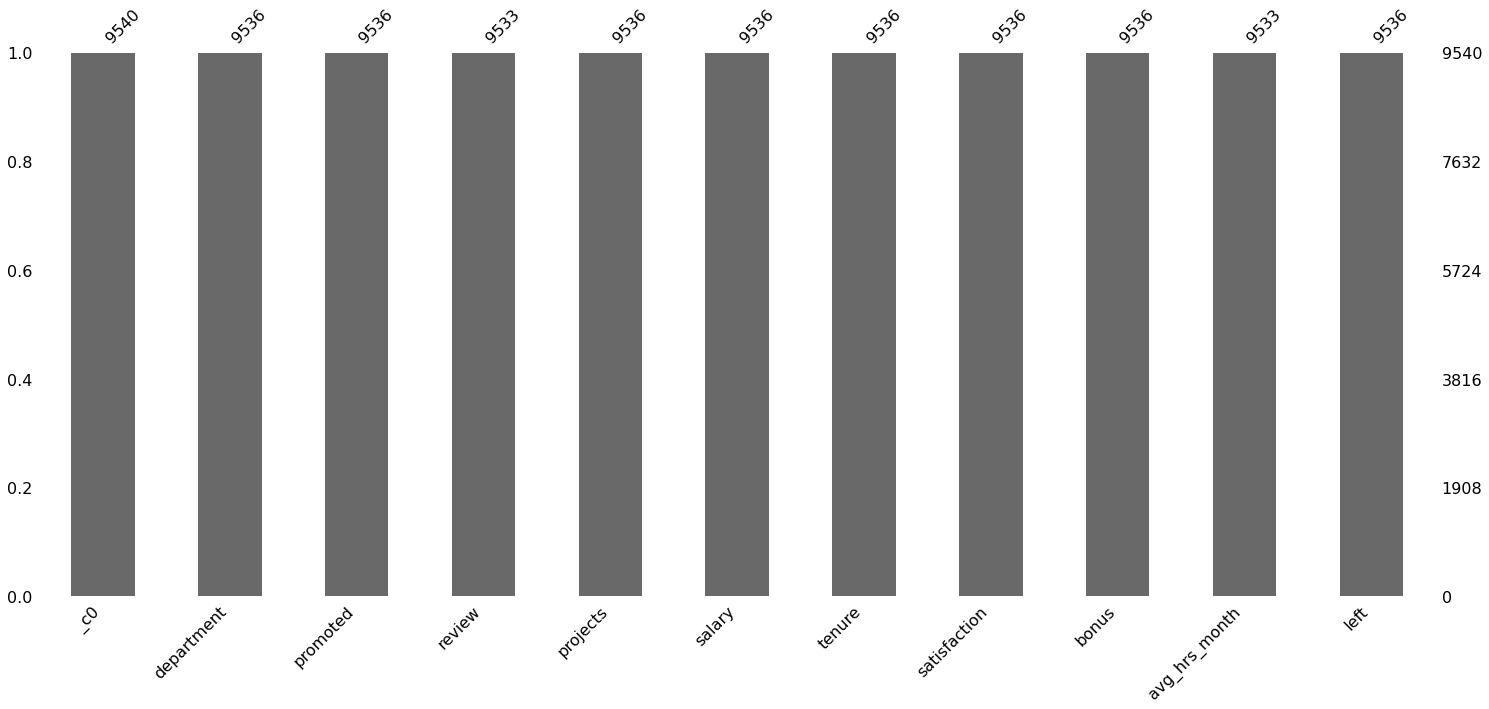

In [ ]:
employees_df = employees.toPandas()
msno.bar(employees_df)
plt.show()

 ❗❗❗ Toate coloanele au cel putin 4 valori lipsa. Avand in vedere ca in total sunt 9540 de angajati in dataset, putem sterge cele 4 valori nule prezente in fiecare coloana, insa am decis ca mai intai sa completam valorile nule din coloanele `review` si `avg_hrs_month` cu media acestora, apoi pentru celelalte coloane sa stergem definitiv valorile nule.

In [ ]:
# numarul de randuri goale pentru coloana review
missing = employees.where(employees['review'].isNull()).count()
print(missing, 'valori lipsesc in coloana review')

7 valori lipsesc in coloana review


In [ ]:
mean_review = employees.agg({'review': 'mean'}).collect()[0][0]
print(mean_review)

employees = employees.fillna(mean_review, subset=['review'])
print('Dupa inlocuirea cu media a valorilor nule, in coloana review mai sunt',
      employees.filter('review IS NULL').count(), 'valori nule.')

0.6518538109979777
Dupa inlocuirea cu media a valorilor nule, in coloana review mai sunt 0 valori nule.


In [ ]:
# facem acelasi lucru pentru coloana avg_hrs_month
mean_avg_hrs = employees.agg({'avg_hrs_month': 'mean'}).collect()[0][0]
print(mean_avg_hrs)

employees.fillna(value=mean_avg_hrs, subset=['avg_hrs_month'])
print('Dupa inlocuirea cu media a valorilor nule, in coloana avg_hrs_month mai sunt',
      employees.filter('avg_hrs_month IS NULL').count(), 'valori nule.')

184.6611250852271
Dupa inlocuirea cu media a valorilor nule, in coloana avg_hrs_month mai sunt 7 valori nule.


In [ ]:
# eliminam valorile nule din dataset
employees = employees.dropna()

In [ ]:
# verificam ca modificarile facute sa aiba efect
employees.createOrReplaceTempView("employees")
spark.sql("SELECT COUNT(*) FROM employees where review IS NULL").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



### 1.3 Pentru coloanele `review`, `satisfaction` si `avg_hrs_month` vom modifica valorile lor prin a avea doar doua zecimale





In [ ]:
employees = employees.withColumn("review", F.round(employees.review, 2))
employees = employees.withColumn("satisfaction", F.round(employees.satisfaction, 2))
employees = employees.withColumn("avg_hrs_month", F.round(employees.avg_hrs_month, 2))

In [ ]:
employees.show(10)

+---+----------+--------+------+--------+------+------+------------+-----+-------------+----+
|_c0|department|promoted|review|projects|salary|tenure|satisfaction|bonus|avg_hrs_month|left|
+---+----------+--------+------+--------+------+------+------------+-----+-------------+----+
|  0|operations|   false|  0.58|     3.0|   low|   5.0|        0.63|false|       180.87|  no|
|  1|operations|   false|  0.75|     3.0|medium|   6.0|        0.44|false|       182.71|  no|
|  2|   support|   false|  0.72|     3.0|medium|   6.0|        0.45|false|       184.42|  no|
|  3| logistics|   false|  0.68|     4.0|  high|   8.0|        0.44|false|       188.71|  no|
|  4|     sales|   false|  0.68|     3.0|  high|   5.0|        0.58|false|       179.82|  no|
|  5|        IT|   false|  0.68|     2.0|medium|   5.0|        0.57|false|       178.84|  no|
|  6|     admin|   false|  0.62|     4.0|  high|   5.0|        0.69|false|       181.14|  no|
|  7|   support|   false|   0.5|     4.0|medium|   7.0|     

In [ ]:
print('Dupa curatarea datelor, avem', employees.count(), 'angajati.')

Dupa curatarea datelor, avem 9533 angajati.




---



## 2. 🧭 Explorarea Datelor

Acum ca avem datele curatate, vom incerca sa exploram mai in detaliu setul de date si sa extragem informatii importante.

Ce ne propunem sa aflam in aceasta etapa:

✅ Cati angajati au plecat pana acum din companie?

✅ Cat lucreaza in medie angajatii la aceasta companie? Care este in medie satisfactia lor? In urma evaluarii lor, ce se constata? La cate proiecte lucreaza in medie? Cate ore lucreaza pe luna?

✅ Care este departamentul cu cei mai multi angajati care au plecat? Dar cu cei mai putini?

✅ Care este procentul de plecare a angajatilor pe departamente?

✅ Cati angajati au plecat luand in vedere daca au fost promovati sau nu? Dar daca au primit bonusuri?

✅ Ce efect are salariul asupra celor care au plecat?

✅ La cate proiecte lucrau cei care plecat?

✅ Dupa cati ani au decis angajatii sa plece?

✅ Ce impact are satisfactia angajatilor asupra plecarii lor? Dar review-ul acestora?

✅ Cate ore lucrau angajatii pe luna pana sa plece?

In [ ]:
# intrebarea nr 1: cati oameni au plecat pana acum din companie?
prop_people_left = employees.filter(employees['left'] == 'yes').count() / employees.count() * 100

print(f"Pana acum, din companie au plecat {Fore.RED}{prop_people_left:.2f}%{Style.RESET_ALL} din toti angajatii.")

Pana acum, din companie au plecat 29.18% din toti angajatii.


In [ ]:
# cati oameni au primit bonusuri?
prop_people_with_bonus = employees.filter(employees['bonus'] == True).count() / employees.count() * 100

print(f"Pana acum, au primit bonus {Fore.GREEN}{prop_people_with_bonus:.2f}%{Style.RESET_ALL} din toti angajatii.")

Pana acum, au primit bonus 3.03% din toti angajatii.


In [ ]:
# intrebarea nr 2: Date statistice despre angajati
employees.describe().show()

+-------+-----------------+----------+-------------------+------------------+------+-----------------+-------------------+------------------+----+
|summary|              _c0|department|             review|          projects|salary|           tenure|       satisfaction|     avg_hrs_month|left|
+-------+-----------------+----------+-------------------+------------------+------+-----------------+-------------------+------------------+----+
|  count|             9533|      9533|               9533|              9533|  9533|             9533|               9533|              9533|9533|
|   mean|4769.999685303682|      null| 0.6518955208224081|3.2748347844330223|  null|6.555963495227106| 0.5045547047099559|184.66110668205096|null|
| stddev|2753.373384798771|      null|0.08530354082136132|0.5792188063214656|  null|1.415599852068631|0.15856920142620914| 4.145216418849116|null|
|    min|                0|        IT|               0.31|               2.0|  high|              2.0|                

❗❗❗ Media anilor de lucru este de 6.55 ani. Totodata, in urma evaluarilor, media Review-urilor angajatilor este 0.65. Aceste doua metrici ne arata ca angajatii in general tind sa stea destul de mult in companie si sa isi desfasoare activitatea destul de bine.

❗❗❗Numarul medii de Proiecte este 3, iar media orelor lucrate pe luna este 184-185 ore, ceea ce este destul de normal.

❗❗❗ Satisfactia angajatilor pare un pic ingrijoratoare intrucat media este de 0.50.

❗❗❗ Se remarca ceva foarte interesant in ceea ce priveste vechimea angajatilor,
cel mai "nou" angajat are o vechime de doi ani, ceea ce inseamna ca aceasta corporatie nu a mai facut angajari recente.


In [ ]:
# intrebarea nr 4: Care este departamentul cu cei mai multi angajati care au plecat? Dar cu cei mai putini?
# intrebarea nr 5: Care este procentul de plecare a angajatilor pe departamente?
employees_dept = employees.filter(employees.left == 'yes').groupBy('department').count()
employees_dept = employees_dept.withColumnRenamed("count", "count_yes")
employees_dept.show()

employees_dept2 = employees.groupBy('department').count()
employees_dept = employees_dept.join(employees_dept2, on="department")
employees_dept.show()

employees_dept = employees_dept.withColumn('percentage', F.round(F.col('count_yes') / F.col('count') * 100, 2))
employees_dept = employees_dept.orderBy('percentage', ascending=False)
employees_dept.show()

+-----------+---------+
| department|count_yes|
+-----------+---------+
|    finance|      108|
|  marketing|      243|
|      sales|      537|
|    support|      212|
|     retail|      470|
|  logistics|      111|
|         IT|      110|
|      admin|      119|
| operations|      435|
|engineering|      437|
+-----------+---------+

+-----------+---------+-----+
| department|count_yes|count|
+-----------+---------+-----+
|    finance|      108|  402|
|  marketing|      243|  801|
|      sales|      537| 1883|
|    support|      212|  733|
|     retail|      470| 1540|
|  logistics|      111|  360|
|         IT|      110|  356|
|      admin|      119|  422|
| operations|      435| 1521|
|engineering|      437| 1515|
+-----------+---------+-----+

+-----------+---------+-----+----------+
| department|count_yes|count|percentage|
+-----------+---------+-----+----------+
|         IT|      110|  356|      30.9|
|  logistics|      111|  360|     30.83|
|     retail|      470| 1540|     30.

In [ ]:
palette = sns.color_palette('Blues', n_colors=10)
palette.reverse()

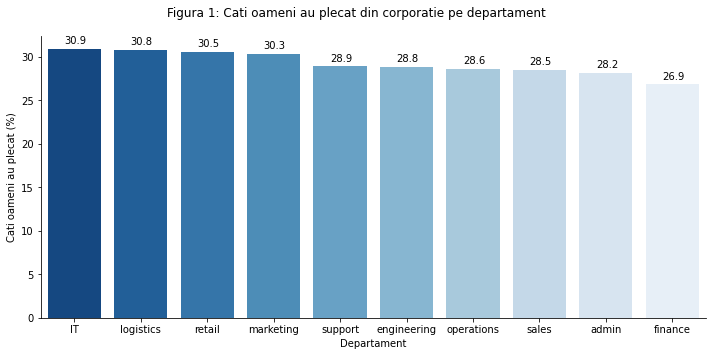

In [ ]:
employees_dept_pd = employees_dept.toPandas()

p = sns.catplot(x='department', y='percentage', data=employees_dept_pd, kind='bar', height=5, 
                 aspect=2, saturation=0.8, palette=palette)
p.set_axis_labels('Departament', 'Cati oameni au plecat (%)')
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Figura 1: Cati oameni au plecat din corporatie pe departament")

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = p.facet_axis(0,0)
# iterate through the axes patches
for pat in ax.patches:
    ax.text(pat.get_x() + 0.25, 
            pat.get_height() * 1.02, 
           '{0:.1f}'.format(pat.get_height()),
            color='black', 
            rotation = 'horizontal', 
            size = 'medium')

❗❗❗ Figura 1 indica faptul ca **cea mai mare rata** de plecare a angajatilor se remarca in **departamentul de IT (30.9%)**, iar **cea mai mica rata** este inregistrata in **departamentul de Finante** **(26.9%)**.

In [ ]:
# intrebarea nr 6: Cum au plecat angajatii in functie de promovare?

# v1: Utilizam Dataframes
employees_promotion = employees.filter(employees.left == 'yes').groupBy('promoted').count()
employees_promotion_all = employees_dept2 = employees.groupBy('promoted').count()
employees_promotion = employees_promotion.withColumnRenamed("count", "count_yes")
employees_promotion = employees_promotion.join(employees_promotion_all, on="promoted")
employees_promotion = employees_promotion.withColumn('percentage', F.round(F.col('count_yes') / F.col('count') * 100, 2))
employees_promotion.show()

+--------+---------+-----+----------+
|promoted|count_yes|count|percentage|
+--------+---------+-----+----------+
|    true|       57|  289|     19.72|
|   false|     2725| 9244|     29.48|
+--------+---------+-----+----------+



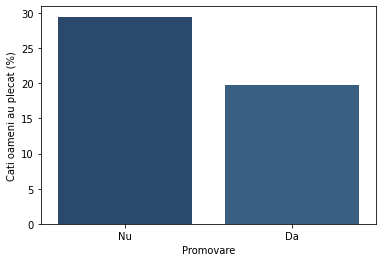

In [ ]:
employees_promotion_pandas = employees_promotion.toPandas()
pr = sns.barplot(x='promoted',
                 y='percentage',
                 data=employees_promotion_pandas, 
                 saturation=0.5,
                 palette=palette)

pr.set(xlabel="Promovare", 
       ylabel="Cati oameni au plecat (%)")

pr.set_xticklabels(["Nu", "Da"])
plt.show()

❗❗❗ Figura de mai sus ne arata ca au plecat mai multi oameni care nu au fost promovati fata de cei care au fost promovati. (**Diferenta de 10%**)

In [ ]:
# v2: Utilizand Spark SQL
employees.createOrReplaceTempView("employees")

query_1 = """
        SELECT promoted, COUNT(*) AS count_yes
        FROM employees
        WHERE left = 'yes'
        GROUP BY promoted
"""


query_2 = """
        SELECT promoted, COUNT(*) AS count_total
        FROM employees
        GROUP BY promoted
"""
employees_p = spark.sql(query_1)
employees_t = spark.sql(query_2)

employees_p.createOrReplaceTempView("employees_p")
employees_t.createOrReplaceTempView("employees_t")

query_3 = """
        SELECT promoted, count_yes, count_total
        FROM employees_p 
        JOIN employees_t
        USING (promoted)

"""
employees_p = spark.sql(query_3)
employees_p = employees_p.withColumn('percentage', F.round(F.col('count_yes') / F.col('count_total') * 100, 2))
employees_p.show()

+--------+---------+-----------+----------+
|promoted|count_yes|count_total|percentage|
+--------+---------+-----------+----------+
|    true|       57|        289|     19.72|
|   false|     2725|       9244|     29.48|
+--------+---------+-----------+----------+



In [ ]:
# intrebarea nr 7: Plecarea angajatilor in functie de salariul acestora
employees_salary = employees.filter(employees.left == 'yes') \
                            .groupBy('salary') \
                            .count() \
                            .withColumnRenamed("count", "count_yes")

employees_salary_all = employees.groupBy('salary') \
                                .count()

employees_salary = employees_salary.join(employees_salary_all, on="salary") \
                                    .withColumn('percentage', \
                                                F.round(F.col('count_yes') / F.col('count') * 100, 2))
employees_salary.show()

+------+---------+-----+----------+
|salary|count_yes|count|percentage|
+------+---------+-----+----------+
|   low|      391| 1380|     28.33|
|  high|      442| 1548|     28.55|
|medium|     1949| 6605|     29.51|
+------+---------+-----+----------+



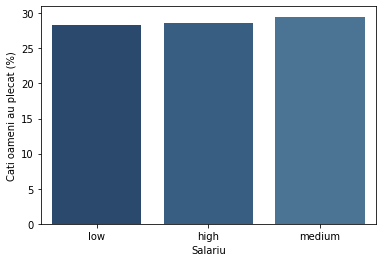

In [ ]:
employees_salary_pandas = employees_salary.toPandas()

pr = sns.barplot(x='salary',
                 y='percentage', 
                 data=employees_salary_pandas, 
                 saturation=0.5,
                 palette=palette)

pr.set(xlabel="Salariu", ylabel="Cati oameni au plecat (%)")
plt.show()

❗❗❗In functie de salariu, nu se remarca diferente foarte mari in ceea ce priveste plecarea angajatilor. Putem observa totusi ca **cei mai multi care pleaca** sunt cei cu **salariul mediu**.

In [ ]:
# intrebarea 8: Plecarea angajatilor in functie de numarul de proiectele la care lucreaza
employees_projects = employees.filter(employees.left == 'yes') \
                    .groupBy('projects') \
                    .count() \
                    .withColumnRenamed("count", "count_yes")

employees_projects_all = employees.groupBy('projects') \
                        .count()

employees_projects = employees_projects.join(employees_projects_all, on="projects") \
                    .withColumn('percentage', \
                                F.round(F.col('count_yes') / F.col('count') * 100, 2))

employees_projects.show()


+--------+---------+-----+----------+
|projects|count_yes|count|percentage|
+--------+---------+-----+----------+
|     4.0|      869| 3056|     28.44|
|     3.0|     1718| 5828|     29.48|
|     2.0|      175|  578|     30.28|
|     5.0|       20|   71|     28.17|
+--------+---------+-----+----------+



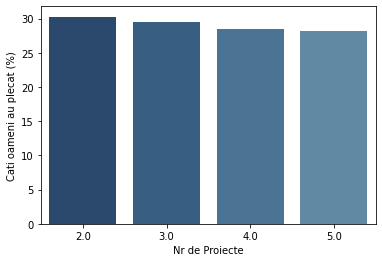

In [ ]:
employees_projects_pandas = employees_projects.toPandas()

pr = sns.barplot(x='projects',
                 y='percentage',
                 data=employees_projects_pandas, saturation=0.5,
                 palette=palette)

pr.set(xlabel="Nr de Proiecte", ylabel="Cati oameni au plecat (%)")

plt.show()

❗❗❗Nici in ceea ce priveste proiectele nu se remarca diferente foarte mari cand vine vorba de plecarea angajatilor, sunt prezente mici diferente intre cei cu mai multe proiecte si cei cu mai putine.

In [ ]:
# intrebarea 9: Plecarea angajatilor in functie de vechimea acestora in companie
employees_tenure = employees.filter(employees.left == 'yes') \
                    .groupBy('tenure') \
                    .count() \
                    .withColumnRenamed("count", "count_yes")

employees_tenure_all = employees.groupBy('tenure') \
                        .count()

employees_tenure = employees_tenure.join(employees_tenure_all, on="tenure") \
                    .withColumn('percentage', \
                                F.round(F.col('count_yes') / F.col('count') * 100, 2)) \
                    .orderBy('tenure')

employees_tenure.show()

+------+---------+-----+----------+
|tenure|count_yes|count|percentage|
+------+---------+-----+----------+
|   2.0|        2|    3|     66.67|
|   3.0|       30|   57|     52.63|
|   4.0|      186|  518|     35.91|
|   5.0|      428| 1822|     23.49|
|   6.0|      478| 2311|     20.68|
|   7.0|      823| 2208|     37.27|
|   8.0|      821| 1885|     43.55|
|   9.0|       14|  578|      2.42|
+------+---------+-----+----------+



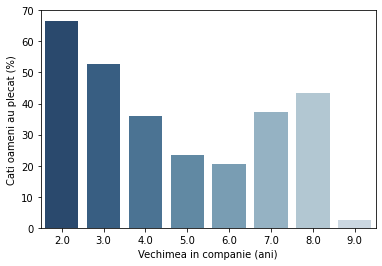

In [ ]:
employees_tenure_pandas = employees_tenure.toPandas()

pr = sns.barplot(x='tenure',
                 y='percentage',
                 data=employees_tenure_pandas, 
                 saturation=0.5,
                palette=palette)

pr.set(xlabel="Vechimea in companie (ani)", ylabel="Cati oameni au plecat (%)")

plt.show()

❗❗❗In cazul vechimii angajatilor in companie, se poate remarca o relatie mai complexa in legatura cu plecarea angajatilor. Cea mai mare proportie a angajatilor care au plecat in companie a fost dupa ce acestia au stat 2 ani in companie, apoi proportia a scazut continuu pana in anul 6 cand din nou se remarca o crestere a numarului de plecari a angajatilor. In anul 9 se remarca nu mai pleaca aproape nimeni. 

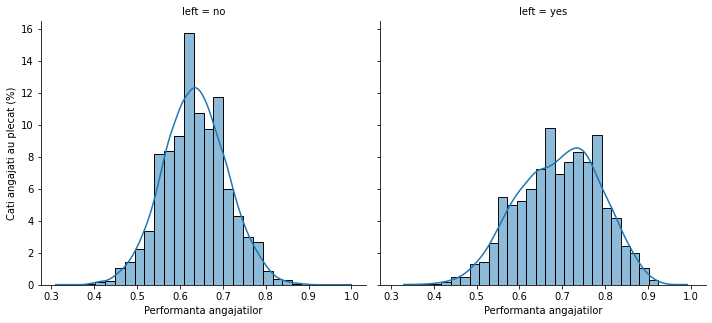

In [ ]:
# intrebarea 10: Plecarea angajatilor in functie de evaluarea performantei acestora (scorul de review)
employees_pandas = employees.toPandas()
r = sns.FacetGrid(employees_pandas, col='left', height=5, aspect=1)
r.map_dataframe(sns.histplot, x="review", kde=True, stat='percent', bins=30)
r.set_axis_labels("Performanta angajatilor", "Cati angajati au plecat (%)")
r.fig.subplots_adjust(top=0.85)

❗❗❗ Avand in vedere figura de mai sus in care sunt plotate distributiile angajatiilor care au plecat si care nu au plecat in functie de performanta, se remarca un lucru foarte interesant in graficul din dreapta, ***cei care au plecat au un scor al performantei mai mare***.

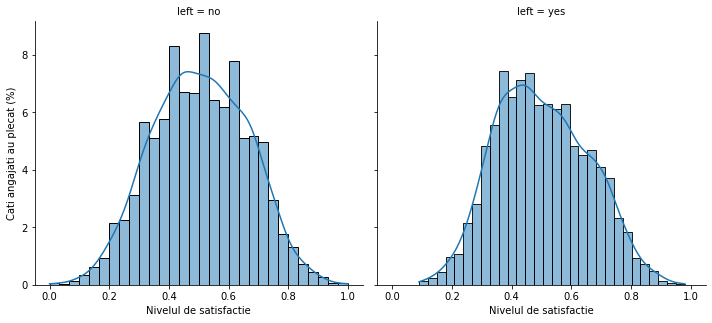

In [ ]:
# intrebarea 11: Plecarea angajatilor in functie de satisfactia acestora la locul de munca
s = sns.FacetGrid(employees_pandas, col="left", height=5, aspect=1)
s.map_dataframe(sns.histplot, x="satisfaction", kde=True, stat='percent', bins=30)
s.set_axis_labels("Nivelul de satisfactie", "Cati angajati au plecat (%)")
s.fig.subplots_adjust(top=0.85)

❗❗❗Din figura de mai sus in care este prezentata distributia angajatilor in cele doua cazuri (cand nu au plecat din companie si cand au plecat), se remarca faptul ca ***cei care au fost mai putin satisfacuti la locul de munca au fost cei care au plecat***.

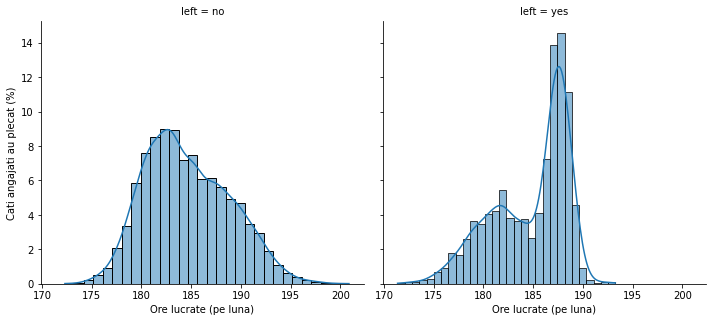

In [ ]:
# intrebarea 12: Plecarea angajatilor in functie de cat de mult timp lucreaza
h = sns.FacetGrid(employees_pandas, col="left", height=5, aspect=1)
h.map_dataframe(sns.histplot, x="avg_hrs_month", kde=True, stat='percent', bins=30)
h.set_axis_labels("Ore lucrate (pe luna)", "Cati angajati au plecat (%)")
h.fig.subplots_adjust(top=0.85)

❗❗❗Este clar din figura de mai sus ca o ***mare parte din cei care au plecat au lucrat mai multe ore*** fata de cei care nu au plecat din companie.



---



## 3. 〽️ Angajatii pleaca sau nu? O problema de clasificare.
Avand in vedere cerintele proiectului, partea de explorare a setului de date este suficienta, insa exista multe metoda care sa ne spuna exact ce influenta are asupra angajatilor fiecare predictor astfel incat acesta sa ia decizia sa plece. 

❗ Din analiza de pana acum, vom lua in considerare ca predictori:

✅ orele lucrate pe luna (`avg_hrs_month`), 

✅ satisfactia angajatilor (`satisfaction`),

✅ scorul lor de performanta (`review`),

✅ vechimea angajatilor in companie (`tenure`).

Ca si algoritmi de clasificare, vom folosi clasificatorii **Logistic Regression** si **Gradient Boosted Trees**. Rezultatele acestora le vom compara prin doua metrici:

- acuratete

- AUC 

Pe de alta parte, doar pentru scopul acestui proiect si pentru a folosi cat mai multe notiuni, pentru clasificatorul cu cele mai bune metrici de performanta vom folosi ca si predictori toate variabilele. Apoi vom compara rezultatele.

Avem 3 variabile categorice pe care le vom transforma folosind *StringIndexer*: 

- `department` (It, finance etc)

- `salary` (low, medium, high)

- `left` (yes, no)

Pentru coloana `department` (care are 10 valori unice) vom folosi *OneHotEncoder*, creand o coloana noua.

Vom ansambla apoi toate coloanele predictor folosind *VectorAssembler* si creand astfel o noua coloana denumita `features`, iar apoi vom aplica clasificatorii de *Regresie Logistica* si *Gradient Boosted Trees*.

❗ Primul exemplu (*Regresie Logistica*) il vom face pas cu pas, iar cel de *Gradient Boosting* il vom face construind un pipeline. 

❗Vom crea si o functie care sa evalueze modelele pe care le cream.

In [ ]:
def evaluate_model(predictions_test):
  '''Evalueaza modelul creat. Returneaza accuratetea si AUC-ul pentru model.'''

  evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
  acc = evaluator.evaluate(predictions_test, {evaluator.metricName: 'accuracy'})

  binEval = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
  auc = binEval.evaluate(predictions_test)

  return (acc, auc)

In [ ]:
employees_0 = employees.select('*')

### Clasificator Logistic Regression (fara pipeline, fiecare etapa se face pas cu pas):

In [ ]:
# facem o copie la employees
employees2 = employees.select('*')

In [ ]:
indexer = StringIndexer(inputCols=['department', 'salary', 'left'], outputCols=['department_idx','salary_idx', 'label'])
employees2 = indexer.fit(employees2).transform(employees2)

In [ ]:
onehot = OneHotEncoder(inputCols=['department_idx'], 
                       outputCols=['department_dummy'])
onehot = onehot.fit(employees2)
employees2 = onehot.transform(employees2)

# how many category levels?
print(onehot.categorySizes, 'nivele')

employees2.select('department', 'department_idx', 'department_dummy').distinct() \
         .sort('department_idx').show()

[10] nivele
+-----------+--------------+----------------+
| department|department_idx|department_dummy|
+-----------+--------------+----------------+
|      sales|           0.0|   (9,[0],[1.0])|
|     retail|           1.0|   (9,[1],[1.0])|
| operations|           2.0|   (9,[2],[1.0])|
|engineering|           3.0|   (9,[3],[1.0])|
|  marketing|           4.0|   (9,[4],[1.0])|
|    support|           5.0|   (9,[5],[1.0])|
|      admin|           6.0|   (9,[6],[1.0])|
|    finance|           7.0|   (9,[7],[1.0])|
|  logistics|           8.0|   (9,[8],[1.0])|
|         IT|           9.0|       (9,[],[])|
+-----------+--------------+----------------+



In [ ]:
assembler = VectorAssembler(inputCols=[ 'review', 'tenure',
                                       'satisfaction','avg_hrs_month', 
                                      ], 
                            outputCol='features')
employees2_assembled = assembler.transform(employees2)

employees2_assembled.select('features', 'label').show(5, truncate=False)

+----------------------+-----+
|features              |label|
+----------------------+-----+
|[0.58,5.0,0.63,180.87]|0.0  |
|[0.75,6.0,0.44,182.71]|0.0  |
|[0.72,6.0,0.45,184.42]|0.0  |
|[0.68,8.0,0.44,188.71]|0.0  |
|[0.68,5.0,0.58,179.82]|0.0  |
+----------------------+-----+
only showing top 5 rows



In [ ]:
# impartirea setului de date: 80% date de antrebare si 20% date de test
# pentru a avea aceleasi rezultate, setam seed=23
employees_train, employees_test = employees2_assembled.randomSplit([0.8, 0.2], seed=23)

In [ ]:
# verificare
[employees_train.count(), employees_test.count()]

[7583, 1950]

In [ ]:
# crearea unui model de clasificare folosind regresia logistica
logistic = LogisticRegression(labelCol='label')
logistic = logistic.fit(employees_train)
predictions = logistic.transform(employees_test)
predictions.select('label', 'prediction', 'probability').show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.84795276389005...|
|  0.0|       0.0|[0.89420248138860...|
|  0.0|       0.0|[0.66127993065477...|
|  0.0|       1.0|[0.45577843827589...|
|  0.0|       0.0|[0.93010152482697...|
|  0.0|       0.0|[0.80101242108601...|
|  0.0|       0.0|[0.80762773960052...|
|  0.0|       0.0|[0.72669570203678...|
|  0.0|       0.0|[0.83566454033321...|
|  0.0|       0.0|[0.69592110626234...|
|  0.0|       0.0|[0.88575230891931...|
|  0.0|       0.0|[0.66419451524390...|
|  0.0|       0.0|[0.58606046684988...|
|  0.0|       0.0|[0.68540875539051...|
|  0.0|       0.0|[0.80391333603480...|
|  0.0|       0.0|[0.85913663354640...|
|  0.0|       0.0|[0.86343877601593...|
|  0.0|       0.0|[0.65322728958933...|
|  0.0|       1.0|[0.48973138260200...|
|  0.0|       0.0|[0.58047824446137...|
+-----+----------+--------------------+
only showing top 20 rows



In [ ]:
# Evaluarea modelului de regresie logistica 
acc_rl, auc_rl = evaluate_model(predictions)

print('Acuratetea clasificatorui de Regresie Logistica este:', acc_rl)
print('AUC pentru clasificatorul de Regresie Logistica:',  auc_rl)

Acuratetea clasificatorui de Regresie Logistica este: 0.7292307692307692
AUC pentru clasificatorul de Regresie Logistica: 0.7294192417269352


### Clasificator - Gradient Boosted Tree (+ pipeline):

In [ ]:
employees3 = employees.select('*')

In [ ]:
# Gradient Boosted Tree + using pipeline
indexer = StringIndexer(inputCols=['department', 'salary', 'left'], 
                        outputCols=['department_idx','salary_idx', 'label'])

onehot = OneHotEncoder(inputCols=['department_idx'], 
                         outputCols=['department_dummy'])

assembler = VectorAssembler(inputCols=[ 'review', 'tenure',
                                       'satisfaction','avg_hrs_month', 
                                      ], 
                            outputCol='features')

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

pipeline2 = Pipeline(stages=[indexer, onehot, assembler, gbt])

In [ ]:
employees_train, employees_test = employees3.randomSplit([0.8, 0.2], seed=23)

In [ ]:
# pe datele de antrenare
model = pipeline2.fit(employees_train)
predictions = model.transform(employees_train)

In [ ]:
# pe datele de test
predictions_test = model.transform(employees_test)

In [ ]:
# evaluarea modelului de Gradient Boosted Tree
acc_gbt, auc_gbt = evaluate_model(predictions_test)

print('Acuratetea clasificatorui de Gradient Boosted este:', 
      acc_gbt)

print('AUC pentru clasificatorul de Gradient Boosted este:', 
      auc_gbt)


Acuratetea clasificatorui de Gradient Boosted este: 0.8543589743589743
AUC pentru clasificatorul de Gradient Boosted este: 0.9271945148868225


### Gradient Boosted Tree - folosind toti predictorii:

In [ ]:
assembler_all = VectorAssembler(inputCols=['promoted', 'review', 'projects', 'tenure',
                                       'satisfaction', 'bonus', 'avg_hrs_month', 
                                       'department_dummy', 'salary_idx'], 
                            outputCol='features')

pipeline3 = Pipeline(stages=[indexer, onehot, assembler_all, gbt])

# pe datele de antrenare
model = pipeline3.fit(employees_train)
predictions = model.transform(employees_train)

# pe datele de test
predictions_test = model.transform(employees_test)

# evaluarea modelului de Gradient Boosting
# evaluarea modelului de Gradient Boosting
acc_gbt2, auc_gbt2 = evaluate_model(predictions_test)

print('Acuratetea clasificatorui de Gradient Boosted este:', 
      acc_gbt2)

print('AUC pentru clasificatorul de Gradient Boosted:', 
      auc_gbt2)

Acuratetea clasificatorui de Gradient Boosted este: 0.8533333333333334
AUC pentru clasificatorul de Gradient Boosted: 0.9266334804796341


In [ ]:
dict = {'Classifier': ['Logistic Regression', 'Gradient Boosted Tree', 'Gradient Boosting'],
        'Features': ['review, tenure, satisfaction, avg_hrs_month', 'review, tenure, satisfaction, avg_hrs_month', 'all'],
        'accuracy': [acc_rl, acc_gbt, acc_gbt2],
        'AUC': [auc_rl, auc_gbt, auc_gbt2]
        }

result = pd.DataFrame(dict)

result.head()

,Classifier,Features,accuracy,AUC
0,Logistic Regression,"review, tenure, satisfaction, avg_hrs_month",0.729231,0.729419
1,Gradient Boosted Tree,"review, tenure, satisfaction, avg_hrs_month",0.854359,0.927195
2,Gradient Boosting,all,0.853333,0.926633


Avand in vedere aceste rezultate, modelul pe care il alegem va fi al doilea, in care folosim ca si clasificator Gradient Boosted Tree.



---



## 🧠 Aplicarea unei metode de Deep Learning - TensorFlow

Vom folosi aceleasi coloane ca predictori: 

✅ orele lucrate pe luna (`avg_hrs_month`), 

✅ satisfactia angajatilor (`satisfaction`),

✅ scorul lor de performanta (`review`),

✅ vechimea angajatilor in companie (`tenure`).



Vom crea o retea neuronala cu 4 straturi ca in figura de mai jos:

- Primul strat (stratul de input) cu 10 noduri;

- Al doilea strat, al treilea strat, al patrulea strat (straturi ascunse) cu 7, 7 si 3 noduri.

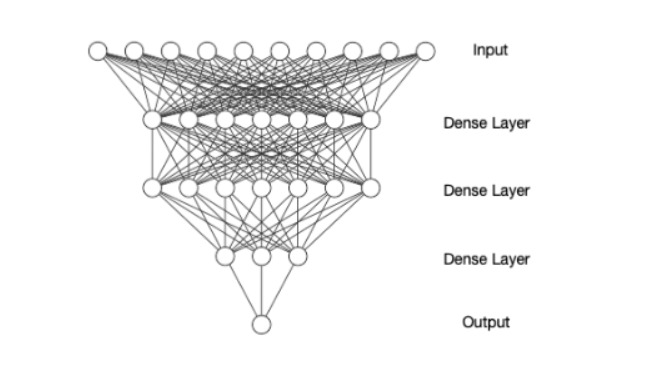

Modelul va fi compilat folosind `optimizorul Adam`, `functia de cost va fi binary_crossentropy` iar ca `metrica` folosita se va lua in calcul `acuratetea modelului`. Totodata, modelul va fi antrenat pentru inceput pentru `40 de epoci` si un `batch de dimensiune 128`.

La final, se va face o optimizare a hiperparametrilor retelei de neuroni, alegandu-se intre `20, 40, 80 de epoci` si o marime a batch-ului de `32, 64 si 128`.

Pe coloanele alese ca predictori se va face o standardizare folosind `scalearea MinMax`.

In [ ]:
employees_pd = employees2.toPandas()
employees_pd.head(2)

,_c0,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,department_idx,salary_idx,label,department_dummy
0,0,operations,False,0.58,3.0,low,5.0,0.63,False,180.87,no,2.0,2.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,1,operations,False,0.75,3.0,medium,6.0,0.44,False,182.71,no,2.0,0.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [ ]:
# setarea predictorilor si a variabilei care trebuie prezisa
X = employees_pd[['review', 'tenure', 'satisfaction', 'avg_hrs_month']]
y = employees_pd['label']

In [ ]:
X.head(2)

,review,tenure,satisfaction,avg_hrs_month
0,0.58,5.0,0.63,180.87
1,0.75,6.0,0.44,182.71


In [ ]:
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9528    1.0
9529    1.0
9530    1.0
9531    1.0
9532    1.0
Name: label, Length: 9533, dtype: float64

In [ ]:
# standardizare pentru coloane folosind MinMaxScaler
scaler = MinMaxScaler()

standardized_attrs = scaler.fit_transform(X[['review', 'tenure', 'satisfaction', 'avg_hrs_month']])
X[['review', 'tenure', 'satisfaction', 'avg_hrs_month']] = standardized_attrs

X.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,review,tenure,satisfaction,avg_hrs_month
count,9533.000000,9533.000000,9533.000000,9533.000000
mean,0.495501,0.455596,0.504555,0.450699
std,0.123628,0.141560,0.158569,0.140563
min,0.000000,0.000000,0.000000,0.000000
25%,0.405797,0.300000,0.390000,0.342489
50%,0.492754,0.500000,0.500000,0.449644
75%,0.579710,0.600000,0.620000,0.554764
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
# divizam dataset ul in 80% date de antrenare si 20% date de test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=101)

In [ ]:
# construim o retea de neuroni cu 4 straturi
model = Sequential()
model.add(Dense(units=10, activation='relu', input_shape=(4,))) #  first layer
model.add(Dense(units=7, activation='relu')) # second layer 
model.add(Dense(units=7, activation='relu')) # third layer 
model.add(Dense(units=3, activation='relu')) # forth layer 
model.add(Dense(units=1, activation='sigmoid')) # output layer 

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                50        
                                                                 
 dense_11 (Dense)            (None, 7)                 77        
                                                                 
 dense_12 (Dense)            (None, 7)                 56        
                                                                 
 dense_13 (Dense)            (None, 3)                 24        
                                                                 
 dense_14 (Dense)            (None, 1)                 4         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilam modelul utilizând Adam ca optimizor, funcția de cost 
# binary_crossentropy si metrica de adaptare accuratetea.
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Antrenam modelul pentru 40 de epoci cu un batch size de dimensiune 128
history = model.fit(x=X_train, 
                   y=y_train, 
                   epochs=40,
                   validation_data=(X_test, y_test), 
                   verbose=1,batch_size=128)

Epoch 1/40
60/60 [==============================] - 1s 5ms/step - loss: 0.6873 - accuracy: 0.7068 - val_loss: 0.6823 - val_accuracy: 0.6943
Epoch 2/40
60/60 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.7116 - val_loss: 0.6726 - val_accuracy: 0.6943
Epoch 3/40
60/60 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.7116 - val_loss: 0.6640 - val_accuracy: 0.6943
Epoch 4/40
60/60 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.7116 - val_loss: 0.6565 - val_accuracy: 0.6943
Epoch 5/40
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.7116 - val_loss: 0.6498 - val_accuracy: 0.6943
Epoch 6/40
60/60 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.7116 - val_loss: 0.6440 - val_accuracy: 0.6943
Epoch 7/40
60/60 [==============================] - 0s 2ms/step - loss: 0.6356 - accuracy: 0.7116 - val_loss: 0.6391 - val_accuracy: 0.6943
Epoch 8/40
60/60 [==

In [ ]:
# evaluarea modelului 
# vom folosi matricea de confuzie si acuratetea

y_pred = model.predict(X_test).reshape((-1,)) > 0.5
y_pred = y_pred.astype(np.int32)

print('Acuratetea obtinuta in acest caz este:', model.evaluate(X_test, y_test)[1] * 100)
confusion_matrix(y_test, y_pred)

60/60 [==============================] - 0s 1ms/step - loss: 0.6163 - accuracy: 0.6943
Acuratetea obtinuta in acest caz este: 69.4284200668335


array([[1324,    0],
       [ 583,    0]])

Accuratetea obtinuta pe datele de test este 83, 63%.

### Optimizarea hiperparametrilor unei retele de neuroni


In [ ]:
def create_neural_network():
  '''Functie care construieste si returneaza o retea de neuroni cu 4 straturi,
  optimizator = adam, functia de pierdere = binary_crossentropy si metrica folosita
  este acuratetea.
  
  Functia returneaza modelul creat.
  '''

  model = Sequential()
  model.add(Dense(units=10, activation='relu', input_shape=(4,))) #  first layer
  model.add(Dense(units=7, activation='relu')) # second layer 
  model.add(Dense(units=7, activation='relu')) # third layer 
  model.add(Dense(units=3, activation='relu')) # forth layer 
  model.add(Dense(units=1, activation='sigmoid')) # output layer
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  
  return model

In [ ]:
model = KerasClassifier(build_fn=create_neural_network)

dict_params = {"batch_size": [32, 64, 128], "epochs" : [20, 40, 80]}

gscv = GridSearchCV(estimator=model, param_grid=dict_params, scoring = "accuracy", n_jobs = -1)
gscv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/80
239/239 [==============================] - 1s 2ms/step - loss: 0.6283 - accuracy: 0.7116
Epoch 2/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7116
Epoch 3/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5419 - accuracy: 0.7116
Epoch 4/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5301 - accuracy: 0.7116
Epoch 5/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.7116
Epoch 6/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.7335
Epoch 7/80
239/239 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.7499
Epoch 8/80
239/239 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.7539
Epoch 9/80
239/239 [==============================] - 0s 2ms/step - loss: 0.4927 - accuracy: 0.7585
Epoch 10/80
239/239 [==============================] - 0s 2ms/step - loss: 0.4907 - accuracy: 0.7574

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f84a24a5190>,
             n_jobs=-1,
             param_grid={'batch_size': [32, 64, 128], 'epochs': [20, 40, 80]},
             scoring='accuracy')

In [ ]:
print(gscv.best_params_)
print(gscv.best_score_)

{'batch_size': 32, 'epochs': 80}
0.8595607502739403


Am obtinut ca cei mai buni parametri sunt:

✅ Numarul de epoci = 80

✅ Dimensiunea batch-ului = 128.

Cu acesti parametri, obtinem o acuratete de aproape 85%.



---



## 🚩 Concluzii

Scopul acestui proiect a fost reprezentat de studiul problemei plecării angajaților folosind diferite metode și tehnologii de Big Data.

Astfel, am aflat că aproximativ 30% din angajați au plecat în ultimele 24 de luni, ceea ce a dus la reducerea performanței în toate cele 10 departamente ale corporației. Totodată, motivele principale pentru care majoritatea a plecat sunt orele în plus lucrate și un nivel de satisfacție redus al angajatilor. Alt lucru surprinzător este că, din cei care au plecat, angajații cu un scor al performanței bun sunt asociați cu un nivel redus de satisfacție, ceea ce poate indica un semn al burnout-ului. De asemenea, în ultimele 24 de luni, din cei aproximativ 10 000 de angajați doar 3% din ei au primit promovări sau bonusuri. 

Recomandările care se fac sunt în primul rând legate de creșterea satisfacției angajaților, prin reducerea de ore unde este cazul (ceea ce înseamnă și o reducere a numărului de proiecte la care un angajat lucrează simultan), acordarea de bonusuri și promovări. Totodată, având în vedere ca de 2 ani nu a mai fost angajat nimeni, se poate deduce de ce există angajați care lucrează pe mai mult de 2-3 proiecte sau de ce lucrează mai multe ore pe lună decat majoritatea. 

Direcțiile de cercetare pentru acest proiect sunt numeroase. În primul rând se pot folosi și alți clasificatori sau se pot analiza mai în detaliu predictorii care chiar influențează plecarea angajaților. Cu modelele găsite se pot face simulări care să demonstreze mai bine ce măsuri pot minimiza rata de plecare a angajaților.


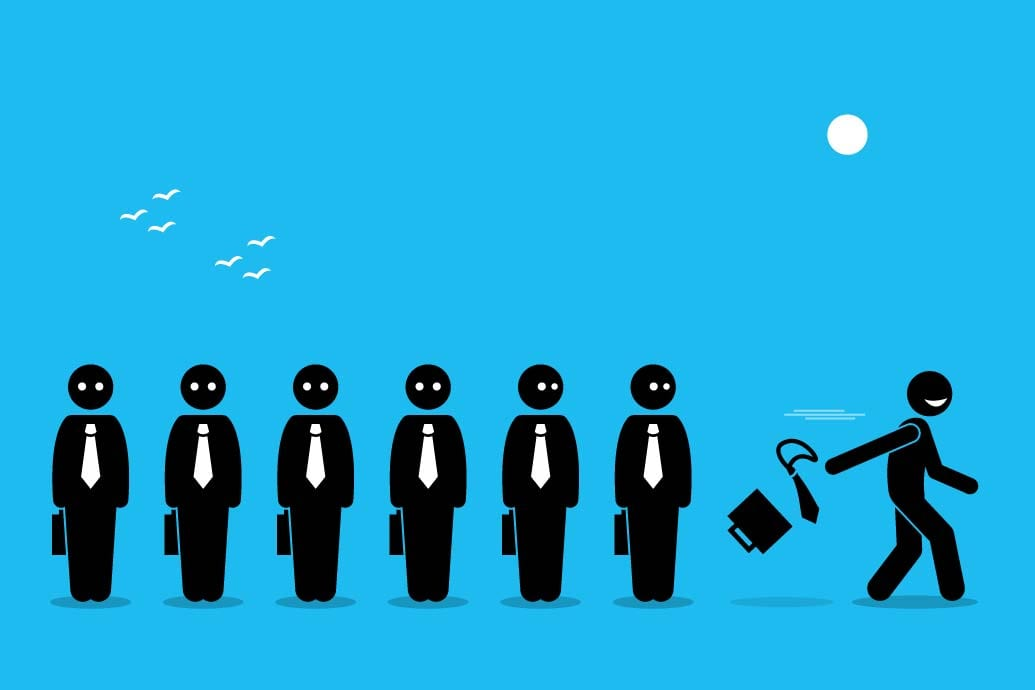